# Object Detection on Traffic Video with Faster-RCNN

Environment: Macbook M1

## Video
Video is located in `./traffic.mp4`. Let's first take a look at a single frame.

In [19]:
import torch
import torch.nn as nn
import cv2
import torchvision
import torchvision.models as models
import torchvision.transforms.functional as F
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes
from PIL import Image
import os
import torchsummary as summary
import matplotlib.pyplot as plt
import numpy as np
import time

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Running on mps")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on mps


Frame size: heightxwidth: 720x1280
Frame 100 extracted and saved as frame.png
Frame size: (1280, 720) <class 'PIL.PngImagePlugin.PngImageFile'>


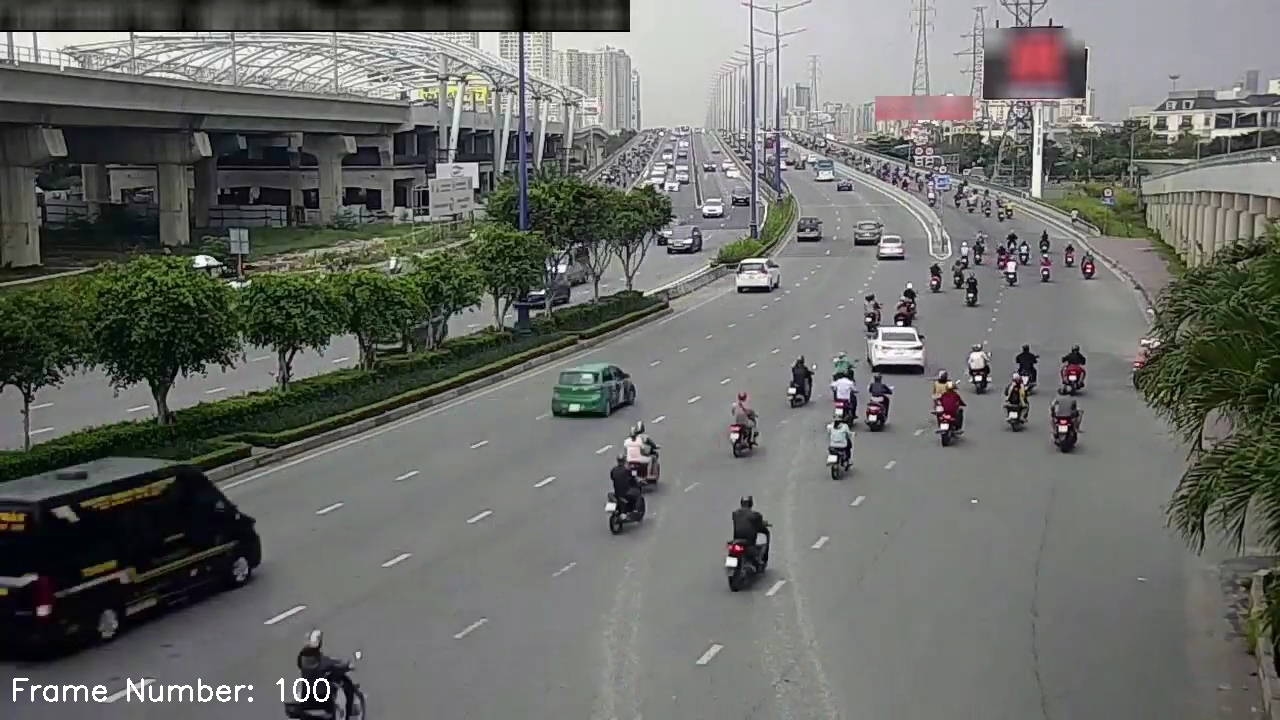

In [20]:
# Extract a frame from a video
video_path = 'traffic.mp4'
cap = cv2.VideoCapture(video_path)
frame_number = 100
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
ret, frame = cap.read()


# get size of the frame
height, width, channels = frame.shape
print(f"Frame size: heightxwidth: {height}x{width}")

if ret:
    frame_output_path = "frame.png"
    # add frame number to the frame
    font = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (10, height - 20)
    fontScale = 1
    fontColor = (255, 255, 255)
    lineType = 2
    cv2.putText(frame, f"Frame Number: {frame_number}", bottomLeftCornerOfText, font, fontScale, fontColor, lineType)
    cv2.imwrite(frame_output_path, frame)
    print(f"Frame {frame_number} extracted and saved as {frame_output_path}")
else:
    print("Error: Could not read frame.")

cap.release()
cv2.destroyAllWindows()

# Show the frame
img = Image.open(frame_output_path)
print(f"Frame size: {img.size}", type(img))
img



## Pretrained Model
We used a pretrained model found [here](https://pytorch.org/vision/main/models/faster_rcnn.html). The labels are trained on the COCO v1 dataset, which are taken from [here](https://github.com/amikelive/coco-labels).

Here we see, the model has a total of 91 different classes.

In [21]:
# Load the model
model_name = "fasterrcnn_resnet50_fpn"
# model_name = "fasterrcnn_mobilenet_v3_large_fpn"
# model_name = "fasterrcnn_mobilenet_v3_large_320_fpn"
model_path = os.path.expanduser(f"~/Developer/Models/{model_name}.pth")
if not os.path.exists(model_path):
    print(f"Downloading model {model_name}...")
    model = models.detection.fasterrcnn_resnet50_fpn(weights=models.detection.FasterRCNN_ResNet50_FPN_Weights)
    # model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(weights=models.detection.FasterRCNN_MobileNet_V3_Large_FPN_Weights)
    # model = models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(weights=models.detection.FasterRCNN_MobileNet_V3_Large_320_FPN_Weights)
    torch.save(model.state_dict(), model_path)
else:
    print(f"Loading model {model_name}...")
    model = models.detection.fasterrcnn_resnet50_fpn(weights=False)
    # model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(weights=False)
    # model = models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(weights=False)
    model.load_state_dict(torch.load(model_path))
    
# Output the model input size and number of classes
print(f"Model input size: {model.transform.min_size}")
print(f"Model number of classes: {model.roi_heads.box_predictor.cls_score.out_features}")

classes_dict = {
    1: "person",
    2: "bicycle",
    3: "car",
    4: "motorcycle",
    5: "airplane",
    6: "bus",
    7: "train",
    8: "truck",
    9: "boat",
    10: "traffic light",
    11: "fire hydrant",
    12: "street sign",
    13: "stop sign",
    14: "parking meter",
    15: "bench",
    16: "bird",
    17: "cat",
    18: "dog",
    19: "horse",
    20: "sheep",
    21: "cow",
    22: "elephant",
    23: "bear",
    24: "zebra",
    25: "giraffe",
    26: "hat",
    27: "backpack",
    28: "umbrella",
    29: "shoe",
    30: "eye glasses",
    31: "handbag",
    32: "tie",
    33: "suitcase",
    34: "frisbee",
    35: "skis",
    36: "snowboard",
    37: "sports ball",
    38: "kite",
    39: "baseball bat",
    40: "baseball glove",
    41: "skateboard",
    42: "surfboard",
    43: "tennis racket",
    44: "bottle",
    45: "plate",
    46: "wine glass",
    47: "cup",
    48: "fork",
    49: "knife",
    50: "spoon",
    51: "bowl",
    52: "banana",
    53: "apple",
    54: "sandwich",
    55: "orange",
    56: "broccoli",
    57: "carrot",
    58: "hot dog",
    59: "pizza",
    60: "donut",
    61: "cake",
    62: "chair",
    63: "couch",
    64: "potted plant",
    65: "bed",
    66: "mirror",
    67: "dining table",
    68: "window",
    69: "desk",
    70: "toilet",
    71: "door",
    72: "tv",
    73: "laptop",
    74: "mouse",
    75: "remote",
    76: "keyboard",
    77: "cell phone",
    78: "microwave",
    79: "oven",
    80: "toaster",
    81: "sink",
    82: "refrigerator",
    83: "blender",
    84: "book",
    85: "clock",
    86: "vase",
    87: "scissors",
    88: "teddy bear",
    89: "hair drier",
    90: "toothbrush",
    91: "hair brush"
}

Loading model fasterrcnn_resnet50_fpn...


/Users/georgeli/Developer/miniconda3/envs/py311/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model input size: (800,)
Model number of classes: 91


## Utils
Below we define some constants and util functions.

In [22]:
# Make inference on img and draw bounding boxes
def show(imgs):
    if not isinstance(imgs, list):
        print("Converting to list")
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)     
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
def save_image(img, path):
    img = img.detach()
    img = F.to_pil_image(img)
    img.save(path)
    
# Show the image
def show_image(tensor: torch.Tensor):
    img = F.to_pil_image(tensor)
    cv2_image = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    cv2.imshow('frame', cv2_image)
    
# Redefine draw_bounding_boxes to draw boxes and labels
def draw_boxes(img_tensor, boxes, scores, labels, classes, colors, threshold=0.5):
    image_numpy = img_tensor.permute(1, 2, 0).numpy()
    for i in range(len(boxes)):
        # add bounding boxes if score is above threshold
        if scores[i] < threshold:
            continue
        box = boxes[i]
        label = labels[i]
        color = colors[label]
        # turn color to rgb
        color = tuple(int(color.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))
        class_ = classes[i]
        x1, y1, x2, y2 = box
        # print(x1, y1, x2, y2, color, class_)
        cv2.rectangle(image_numpy, (int(x1.item()), int(y1.item())), (int(x2.item()), int(y2.item())), color, 2)
        # add text
        font = cv2.FONT_HERSHEY_SIMPLEX
        bottomLeftCornerOfText = (int(x1.item()), int(y1.item())- 10)
        fontScale = 0.2
        fontColor = color
        fontThickness = 1
        cv2.putText(image_numpy, class_, bottomLeftCornerOfText, font, fontScale, fontColor, fontThickness)    
    
    # convert back to tensor
    return torch.from_numpy(image_numpy).permute(2, 0, 1)


In [23]:
# 91 Colors for 91 classes
colors = [
    "#000000",  # Black
    "#FF0000",  # Red
    "#00FF00",  # Lime
    "#0000FF",  # Blue
    "#FFFF00",  # Yellow
    "#00FFFF",  # Cyan / Aqua
    "#FF00FF",  # Magenta / Fuchsia
    "#C0C0C0",  # Silver
    "#808080",  # Gray
    "#800000",  # Maroon
    "#808000",  # Olive
    "#008000",  # Green
    "#800080",  # Purple
    "#008080",  # Teal
    "#000080",  # Navy
    "#FFA07A",  # Light Salmon
    "#FA8072",  # Salmon
    "#E9967A",  # Dark Salmon
    "#F08080",  # Light Coral
    "#CD5C5C",  # Indian Red
    "#DC143C",  # Crimson
    "#B22222",  # Fire Brick
    "#8B0000",  # Dark Red
    "#FF4500",  # Orange Red
    "#FF6347",  # Tomato
    "#FF7F50",  # Coral
    "#FF8C00",  # Dark Orange
    "#FFA500",  # Orange
    "#FFD700",  # Gold
    "#FFFFE0",  # Light Yellow
    "#FFFACD",  # Lemon Chiffon
    "#FAFAD2",  # Light Goldenrod Yellow
    "#FFE4B5",  # Moccasin
    "#FFDAB9",  # Peach Puff
    "#EEE8AA",  # Pale Goldenrod
    "#F0E68C",  # Khaki
    "#BDB76B",  # Dark Khaki
    "#FFFFF0",  # Ivory
    "#FFFAF0",  # Floral White
    "#F5FFFA",  # Mint Cream
    "#F0FFF0",  # Honeydew
    "#F5F5DC",  # Beige
    "#FAEBD7",  # Antique White
    "#D2B48C",  # Tan
    "#DEB887",  # Burlywood
    "#FFDEAD",  # Navajo White
    "#FFE4C4",  # Bisque
    "#FF8C00",  # Dark Orange
    "#D2691E",  # Chocolate
    "#8B4513",  # Saddle Brown
    "#A52A2A",  # Brown
    "#2E8B57",  # Sea Green
    "#3CB371",  # Medium Sea Green
    "#20B2AA",  # Light Sea Green
    "#98FB98",  # Pale Green
    "#00FF7F",  # Spring Green
    "#7FFF00",  # Chartreuse
    "#00FF00",  # Lime Green
    "#32CD32",  # Lime
    "#008000",  # Green
    "#006400",  # Dark Green
    "#00FA9A",  # Medium Spring Green
    "#90EE90",  # Light Green
    "#7CFC00",  # Lawn Green
    "#00FF00",  # Green Yellow
    "#ADFF2F",  # Green Yellow
    "#556B2F",  # Dark Olive Green
    "#228B22",  # Forest Green
    "#008B8B",  # Dark Cyan
    "#20B2AA",  # Light Sea Green
    "#48D1CC",  # Medium Turquoise
    "#40E0D0",  # Turquoise
    "#00CED1",  # Dark Turquoise
    "#AFEEEE",  # Pale Turquoise
    "#E0FFFF",  # Light Cyan
    "#00FFFF",  # Aqua / Cyan
    "#5F9EA0",  # Cadet Blue
    "#4682B4",  # Steel Blue
    "#B0C4DE",  # Light Steel Blue
    "#ADD8E6",  # Light Blue
    "#87CEEB",  # Sky Blue
    "#87CEFA",  # Light Sky Blue
    "#00BFFF",  # Deep Sky Blue
    "#1E90FF",  # Dodger Blue
    "#6495ED",  # Cornflower Blue
    "#7B68EE",  # Medium Slate Blue
    "#4169E1",  # Royal Blue
    "#0000FF",  # Blue
    "#0000CD",  # Medium Blue
    "#00008B",  # Dark Blue
    "#000080",  # Navy
    "#191970",  # Midnight Blue
]

## Object Detection on a Single Frame
Let's first try to perform object detection on a single frame of the video.

Original image tensor: torch.Size([3, 720, 1280]) torch.uint8
tensor([[[ 58,  53,  58,  ..., 157, 157, 157],
         [ 60,  54,  59,  ..., 157, 157, 157],
         [ 63,  58,  62,  ..., 157, 157, 157],
         ...,
         [ 83,  83,  83,  ..., 102, 100, 100],
         [ 83,  83,  83,  ..., 103, 101, 101],
         [ 83,  83,  83,  ..., 103, 101, 101]],

        [[ 61,  56,  61,  ..., 155, 155, 155],
         [ 63,  58,  62,  ..., 155, 155, 155],
         [ 67,  61,  66,  ..., 155, 155, 155],
         ...,
         [ 82,  82,  82,  ..., 100,  97,  97],
         [ 82,  82,  82,  ..., 101,  98,  98],
         [ 82,  82,  82,  ..., 101,  98,  98]],

        [[ 55,  51,  55,  ..., 165, 165, 165],
         [ 58,  52,  56,  ..., 165, 165, 165],
         [ 61,  55,  60,  ..., 165, 165, 165],
         ...,
         [ 89,  89,  89,  ...,  90,  88,  88],
         [ 89,  89,  89,  ...,  91,  89,  89],
         [ 89,  89,  89,  ...,  91,  89,  89]]], dtype=torch.uint8)
Input torch.Size([3, 720,

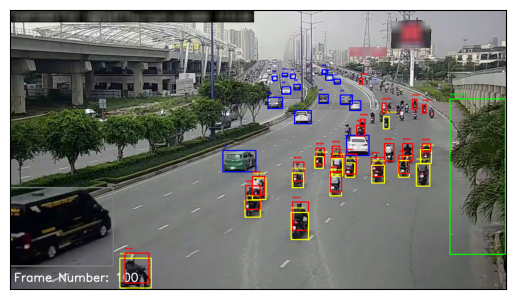

In [24]:
# img to tensor
img_tensor = read_image(frame_output_path)
original_img_tensor = img_tensor.clone()
print(f"Original image tensor: {original_img_tensor.shape} {original_img_tensor.dtype}")
print(original_img_tensor)
print("Input", img_tensor.shape)

# preprocess the image
img_tensor = torchvision.transforms.functional.to_tensor(img)
img_tensor = img_tensor.unsqueeze(0)  # add batch dimension
print(f"Image tensor shape: {img_tensor.shape} {img_tensor.dtype}")
print(img_tensor)

# evaluate the model, time it
model = model.eval()
start_time = time.time()
outputs = model(img_tensor)
emd_time = time.time()
print(f"Time taken: {emd_time - start_time} seconds")
print("Output", len(outputs), outputs[0].keys())

# get the bounding boxes and labels
boxes = outputs[0]["boxes"].detach()
labels = outputs[0]["labels"].detach()
scores = outputs[0]["scores"].detach()
classes = [classes_dict[i.item()] for i in labels]
print("Labels", labels)

print("Unique Classes:", labels.unique())
print("Class Counts:", labels.bincount())

print(f"Labels shape {labels.shape}, Boxes shape {boxes.shape}, Scores shape {scores.shape}")
# result = draw_bounding_boxes(original_img_tensor, boxes=boxes, labels=labels, width=5)
result = draw_boxes(original_img_tensor, boxes=boxes, labels=labels, scores=scores, classes=classes, colors=colors)
show(result)
# Save the image

## Object Detection on Video
Here, we perform bounding boxes on a video. Essentially, it's still just running Faster-RCNN frame by frame.

In [32]:
video_path = 'traffic.mp4'
cap = cv2.VideoCapture(video_path)
height, width, fps, count, framespn = cap.get(cv2.CAP_PROP_FRAME_HEIGHT), cap.get(cv2.CAP_PROP_FRAME_WIDTH), cap.get(cv2.CAP_PROP_FPS), cap.get(cv2.CAP_PROP_FRAME_COUNT), cap.get(cv2.CAP_PROP_POS_FRAMES)
print(height, width, fps, count, framespn)

while(cap.isOpened()):
    ret, frame = cap.read()
    frame_number = cap.get(cv2.CAP_PROP_POS_FRAMES)
    
    # Only run inference every 10 frames
    # if int(frame_number) % 3 != 0:
    #     continue
    
    # print(f"Frame number: {frame_number}")
    
    if ret == True:
        frame_tensor = torchvision.transforms.functional.to_tensor(frame)     # convert to torch of type float32
        original_tensor  = frame_tensor.clone()                               # make a copy of the original tensor
        # print("original_img_tensor", original_img_tensor.shape, original_img_tensor, original_img_tensor.shape, original_img_tensor.dtype)

        img_tensor = torch.from_numpy(frame)                                  # convert to torch of type uint8
        img_tensor = img_tensor.permute(2, 0, 1)                              # permute the dimensions
        # print("img_tensor", img_tensor.shape, img_tensor, img_tensor.shape, img_tensor.dtype)

        # Perform inference
        frame_tensor = frame_tensor.unsqueeze(0)                          # add batch dimension
        model.eval()
        start_time = time.time()
        frame_obj_detect = model(frame_tensor)                            # get the predictions of the frames
        end_time = time.time()
        print(f"Frame number: {frame_number}, Time taken: {end_time - start_time} seconds")
        boxes = frame_obj_detect[0]["boxes"].detach()                     # get the bounding boxes
        labels = frame_obj_detect[0]["labels"].detach()                  # get the classes
        classes = [classes_dict[i.item()] for i in labels]
        scores = frame_obj_detect[0]["scores"].detach()

        # Draw bounding boxes
        # result = draw_bounding_boxes(img_tensor, boxes=boxes, labels=labels, colors=colors, width=5)
        threshold = 0.0
        result = draw_boxes(img_tensor, boxes=boxes, scores=scores, labels=labels, classes=classes, colors=colors, threshold=threshold)

        # Convert to imgs using PIL
        # result.detach()
        # result_img = F.to_pil_image(result)
        # result_img.save(f"./Data/img_{frame_number}.png")
        
        # Convert to imgs using cv2
        result_img = F.to_pil_image(result)
        cv2_image = cv2.cvtColor(np.array(result_img), cv2.COLOR_RGB2BGR)
        cv2.imshow(f'frame', cv2_image)
        
        if int(frame_number) in [99, 198, 297]:
        # if True:
            save_image(result, f"./Data/video/{model_name}_frame_{int(frame_number)}_t{str(threshold)}.png")
        
        if cv2.waitKey(1) & 0xFF == ord('q'): # press q to quit
            break
    else:
        print("Video ended")
        break

cap.release()
# out.release()
cv2.destroyAllWindows()
cv2.destroyWindow('frame')
cv2.waitKey(1)

720.0 1280.0 30.0 885.0 0.0
Frame number: 1.0, Time taken: 1.3759009838104248 seconds
Frame number: 2.0, Time taken: 1.0786139965057373 seconds
Frame number: 3.0, Time taken: 0.9898691177368164 seconds
Frame number: 4.0, Time taken: 0.9398810863494873 seconds
Frame number: 5.0, Time taken: 0.8815028667449951 seconds
Frame number: 6.0, Time taken: 0.9603359699249268 seconds
Frame number: 7.0, Time taken: 0.988483190536499 seconds
Frame number: 8.0, Time taken: 0.9115729331970215 seconds
Frame number: 9.0, Time taken: 0.9036791324615479 seconds
Frame number: 10.0, Time taken: 0.8780040740966797 seconds
Frame number: 11.0, Time taken: 0.8899149894714355 seconds
Frame number: 12.0, Time taken: 0.9653892517089844 seconds
Frame number: 13.0, Time taken: 0.9323127269744873 seconds
Frame number: 14.0, Time taken: 0.8623349666595459 seconds
Frame number: 15.0, Time taken: 0.9184989929199219 seconds
Frame number: 16.0, Time taken: 0.9663219451904297 seconds
Frame number: 17.0, Time taken: 0.9561

-1

In order to draw the boxes, I wrote a `draw_boxes` function. In it, `cv2.rectangle` and `cv2.putText` was used to edit the current frame being inferenced on. I also only drew boxes around objects with a score over a certain threshold, the default threshold is 0.5.

Using the [fasterrcnn_resnet50_fpn](https://pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html#torchvision.models.detection.fasterrcnn_resnet50_fpn) model, I get above 0.8 to 1 second of inference time per frame. The original video quality has 30 frames per second. And even if I perform 1 inference every three frames, a full second of real time would require 10 seconds of processing. Below we show a couple of frames. Below we show the performance of a couple frames with threshold of 0.5.

| 99 | 198 | 297 |
| -- | --- | --- |
| ![](./Data/fasterrcnn_resnet50_fpn_frame_99_t0.5.png) | ![](./Data/fasterrcnn_resnet50_fpn_frame_198_t0.5.png) | ![](./Data/fasterrcnn_resnet50_fpn_frame_297_t0.5.png) |

Let's see all the probable boxes. Threshold is set to 0.

| 99 | 198 | 297 |
| -- | --- | --- |
| ![](./Data/fasterrcnn_resnet50_fpn_frame_99_t0.0.png) | ![](./Data/fasterrcnn_resnet50_fpn_frame_198_t0.0.png) | ![](./Data/fasterrcnn_resnet50_fpn_frame_297_t0.0.png) |

Here is the most accurate model, we can see a lot more classifications, even cars on the other side (left) side of the road.

Using the [fasterrcnn_mobilenet_v3_large_fpn](https://pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn.html#torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn), we get an average of 0.55 to 0.65 seconds per frame. Below, we show a couple of frames. 

| 99 | 198 | 297 |
| -- | --- | --- |
| ![](./Data/fasterrcnn_mobilenet_v3_large_fpn_frame_99_t0.5.png) | ![](./Data/fasterrcnn_mobilenet_v3_large_fpn_frame_198_t0.5.png) | ![](./Data/fasterrcnn_mobilenet_v3_large_fpn_frame_297_t0.5.png) |

Here, we also see a couple misclassifications, such as road lines being classified as birds. THere is also less information thatn the previous model, for example, not classifing the trees, and unable to classify far away cars/objects.

Let's reduce the threshold to 0.2

| 99 | 198 | 297 |
| -- | --- | --- |
| ![](./Data/fasterrcnn_mobilenet_v3_large_fpn_frame_99_t0.5.png) | ![](./Data/fasterrcnn_mobilenet_v3_large_fpn_frame_198_t0.5.png) | ![](./Data/fasterrcnn_mobilenet_v3_large_fpn_frame_297_t0.5.png) | 

Using the [fasterrcnn_mobilenet_v3_large_320_fpn](https://pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn.html#torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn), we get an average of 0.22-0.33 seconds per frame. However, if we keep the threshold of 0.5, the accuracy of this (probability scores of each RoI) is much much lower. It fails to detect smaller image (images far away). It is only able to classify close cars, people, and cyclists. Below we show a couple of frames. 

| 99 | 198 | 297 |
| ---| --- | --- |
| ![](./Data/fasterrcnn_mobilenet_v3_large_320_fpn_frame_99.0.png) | ![](./Data/fasterrcnn_mobilenet_v3_large_320_fpn_frame_198.0.png) | ![](./Data/fasterrcnn_mobilenet_v3_large_320_fpn_frame_297.0.png) |

Let's try with a lower threshold of 0.2.

| 99 | 198 | 297 |
| -- | --- | --- |
| ![](./Data/fasterrcnn_mobilenet_v3_large_320_fpn_frame_198_t0.2.png) | ![](./Data/fasterrcnn_mobilenet_v3_large_320_fpn_frame_297_t0.2.png) | ![](./Data/fasterrcnn_mobilenet_v3_large_320_fpn_frame_297_t0.2.png) |





In [26]:
# Save the model
torch.save(model.state_dict(), model_path)

In [39]:

# Combine the saved frames into a single image
image_folder = './Data/video/'

# Make sure the images are named in order (e.g., image001.jpg, image002.jpg, etc.)
# You can use functions like os.listdir() to list the image files and sort them.
images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
if len(images) == 0:
    print("No images found")
    exit()


# sort images by frame number
images = sorted(images, key=lambda x: int(x.split("_")[-2]))
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

# Define the video file name and codec
video_name = 'output_video.mp4'
fourcc = cv2.VideoWriter_fourcc(*'H264')  # Use H.264 codec for MP4
video = cv2.VideoWriter(video_name, fourcc, 30, (width, height))  # Adjust the frame rate (in this case, 1 frame per second)

for image in images:
    img_path = os.path.join(image_folder, image)
    print(img_path)
    frame = cv2.imread(img_path)
    video.write(frame)

cv2.destroyAllWindows()
video.release()

print("Done")

OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


./Data/video/fasterrcnn_resnet50_fpn_frame_1_t0.0.png
./Data/video/fasterrcnn_resnet50_fpn_frame_2_t0.0.png
./Data/video/fasterrcnn_resnet50_fpn_frame_3_t0.0.png
./Data/video/fasterrcnn_resnet50_fpn_frame_4_t0.0.png
./Data/video/fasterrcnn_resnet50_fpn_frame_5_t0.0.png
./Data/video/fasterrcnn_resnet50_fpn_frame_6_t0.0.png
./Data/video/fasterrcnn_resnet50_fpn_frame_7_t0.0.png
./Data/video/fasterrcnn_resnet50_fpn_frame_8_t0.0.png
./Data/video/fasterrcnn_resnet50_fpn_frame_9_t0.0.png
./Data/video/fasterrcnn_resnet50_fpn_frame_10_t0.0.png
./Data/video/fasterrcnn_resnet50_fpn_frame_11_t0.0.png
./Data/video/fasterrcnn_resnet50_fpn_frame_12_t0.0.png
./Data/video/fasterrcnn_resnet50_fpn_frame_13_t0.0.png
./Data/video/fasterrcnn_resnet50_fpn_frame_14_t0.0.png
./Data/video/fasterrcnn_resnet50_fpn_frame_15_t0.0.png
./Data/video/fasterrcnn_resnet50_fpn_frame_16_t0.0.png
./Data/video/fasterrcnn_resnet50_fpn_frame_17_t0.0.png
./Data/video/fasterrcnn_resnet50_fpn_frame_18_t0.0.png
./Data/video/faster

: 